In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import OpenEXR as exr, Imath
from tqdm import tqdm
from glob import glob
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from utils.cloud import Cloud
from pose_est import PoseEst, create_rot_from_angle, transform_pc, extrinsics_from_rot_transl, get_params_from_rot_and_transl
from params_est import optim_step_ICP, optim_step_neighbors

In [3]:
plot_counter = 0

In [4]:
ksize = 10
gt_extrinsics_dir = f'../data/synthetic/stylized-ww01-plane/blender_render_depth4_3x_more_frames_/'
gt_depth_dir = '../data/synthetic/stylized-ww01-plane/blender_render_depth4_3x_more_frames_'
shared_K_path = f'../data/synthetic/stylized-ww01-plane/blender_render_depth4_3x_more_frames_/K_0.txt'

In [5]:
K = torch.tensor(np.loadtxt(shared_K_path)).double()

In [6]:
K

tensor([[2.6667e+03, 0.0000e+00, 9.6000e+02],
        [0.0000e+00, 2.6667e+03, 5.4000e+02],
        [0.0000e+00, 0.0000e+00, 1.0000e+00]], dtype=torch.float64)

In [7]:
def load_data(depth_dir, gt_extrinsics_dir, indices, gt_depth_dir=None):
    # indices: array-like of int
    depth_all, RT_all, gt_depth_all = [], [], []
    for ind in indices:
        depth = np.load(os.path.join(depth_dir, f'{ind}.npy'))[..., 0]
        RT = np.loadtxt(os.path.join(gt_extrinsics_dir, f'RT_{ind}.txt'))
        depth_all.append(depth)
        RT_all.append(RT)
        if gt_depth_dir is not None:
            gt_depth = np.load(os.path.join(gt_depth_dir, f'{ind}.npy'))
            if len(gt_depth.shape) == 3 and gt_depth.shape[2] == 1:
                gt_depth = gt_depth[..., 0]
            gt_depth_all.append(gt_depth)
    
    depth_all = torch.tensor(np.stack(depth_all)).double()
    RT_all = torch.tensor(np.stack(RT_all)).double()
    if gt_depth_dir is not None:
        gt_depth_all = torch.tensor(np.stack(gt_depth_all)).double()
        return depth_all, RT_all, gt_depth_all
    return depth_all, RT_all

In [8]:
def corrupt_depth(depth, sigma=0.1):
    mask = (depth != depth.max())
    depth_new = depth.clone()
    depth_new[mask] += (np.random.randn(*depth_new.shape) * sigma)[mask]
    return depth_new

In [20]:
depth, extr, gt_depth = load_data(gt_depth_dir, gt_extrinsics_dir, indices=[10, 50], gt_depth_dir=gt_depth_dir)
#depth = corrupt_depth(depth, sigma=0.1)

In [9]:
depth[0].min(), depth[0].max()

(tensor(6.1295, dtype=torch.float64), tensor(15., dtype=torch.float64))

In [10]:
gt_depth[0].min(), gt_depth[0].max()

(tensor(6.1523, dtype=torch.float64), tensor(15., dtype=torch.float64))

In [11]:
depth[1].min(), depth[1].max()

(tensor(6.1591, dtype=torch.float64), tensor(15., dtype=torch.float64))

In [12]:
depth.shape, gt_depth.shape

(torch.Size([2, 1080, 1920]), torch.Size([2, 1080, 1920]))

### Testing visualization

In [21]:
pc1 = Cloud.from_tensors(depth[0], K, extr[0], ignore='max')

In [22]:
pc1.points

tensor([[ 0.7028, -0.3325,  6.2891],
        [ 0.7052, -0.3325,  6.2891],
        [ 0.7071, -0.3323,  6.2852],
        ...,
        [ 0.0399,  0.8502,  6.6484],
        [ 0.0424,  0.8502,  6.6484],
        [ 0.0449,  0.8507,  6.6523]], dtype=torch.float64)

In [23]:
def visualize_pcd(*cloud_objs):
    all_pc_o3d = []
    for cloud in cloud_objs:
        cloud_pts = cloud.points.cpu().data.numpy()
        pc_o3d = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(cloud_pts))
        all_pc_o3d.append(pc_o3d)
    o3d.visualization.draw_geometries(all_pc_o3d)

In [24]:
visualize_pcd(pc1)

### Testing params estimation (ICP correspondence set till convergence + LM till convergence)

In [16]:
depth, extr, gt_depth = load_data(gt_depth_dir, gt_extrinsics_dir, indices=[80, 120], gt_depth_dir=gt_depth_dir)
depth = corrupt_depth(depth, sigma=0.01)

In [17]:
pc0 = Cloud.from_tensors(depth[0], K, torch.eye(4), ignore='max')
# pc1 = Cloud.from_tensors(depth[1], K, torch.eye(4), ignore='max')
# pc0 = Cloud.from_tensors(gt_depth[0], K, torch.eye(4), ignore='max')
pc1 = Cloud.from_tensors(gt_depth[1], K, torch.eye(4), ignore='max')

In [18]:
visualize_pcd(pc0, pc1)

In [19]:
# optimization step & pc0 update:

params = optim_step_ICP(pc0, pc1, max_iter=100, icp_max_iter=30, verbose=1)
transl, angle = params.split([3, 3], dim=-1)
rot = create_rot_from_angle(angle.unsqueeze(0)).squeeze(0)
pc0.points = transform_pc(pc0.points, rot, transl).squeeze(1)
params

Correspondence set estimation...


KeyboardInterrupt: 

In [61]:
visualize_pcd(pc0, pc1)

In [62]:
transl

tensor([-1.8027,  0.0821, -0.0754], dtype=torch.float64)

In [63]:
extrinsics_from_rot_transl(rot, transl)

tensor([[ 0.9647, -0.0272,  0.2619, -1.8027],
        [ 0.0305,  0.9995, -0.0084,  0.0821],
        [-0.2615,  0.0161,  0.9651, -0.0754],
        [ 0.0000,  0.0000,  0.0000,  1.0000]], dtype=torch.float64)

In [64]:
extr[1] @ torch.inverse(extr[0])

tensor([[ 0.9645, -0.0230,  0.2631, -1.8127],
        [ 0.0252,  0.9997, -0.0051,  0.0583],
        [-0.2629,  0.0116,  0.9647, -0.0723],
        [ 0.0000,  0.0000,  0.0000,  1.0000]], dtype=torch.float64)

### Testing params estimation ((ICP correspondence set 1 iteration + LM 1 iteration) x N_iter)

In [96]:
depth, extr, gt_depth = load_data(gt_depth_dir, gt_extrinsics_dir, indices=[80, 120], gt_depth_dir=gt_depth_dir)
depth = corrupt_depth(depth, sigma=0.01)

In [97]:
pc0 = Cloud.from_tensors(depth[0], K, torch.eye(4), ignore='max')
# pc1 = Cloud.from_tensors(depth[1], K, torch.eye(4), ignore='max')
# pc0 = Cloud.from_tensors(gt_depth[0], K, torch.eye(4), ignore='max')
pc1 = Cloud.from_tensors(gt_depth[1], K, torch.eye(4), ignore='max')

In [98]:
visualize_pcd(pc0, pc1)

In [59]:
def loss_T(T_estim, extr_first, extr_second):
    gt_rel_extr = extr_second @ torch.inverse(extr_first)
    loss_val = ((gt_rel_extr - T_estim) ** 2).sum()
    return loss_val

In [60]:
def loss_params(pred_params, extr_first, extr_second):
    gt_rel_extr = extr_second @ torch.inverse(extr_first)
    gt_params = get_params_from_rot_and_transl(gt_rel_extr[:3, :3], gt_rel_extr[:3, 3])
    loss_val = ((pred_params - gt_params) ** 2).sum()
    return loss_val

In [61]:
gradslam_iter = 30

T = torch.eye(4).double()
for i in tqdm(range(gradslam_iter)):
    params_upd = optim_step_ICP(pc0, pc1, max_iter=10, icp_max_iter=1, verbose=0)
    transl_upd, angle_upd = params_upd.split([3, 3], dim=-1)
    rot_upd = create_rot_from_angle(angle_upd.unsqueeze(0)).squeeze(0)
    pc0.points = transform_pc(pc0.points, rot_upd, transl_upd).squeeze(1)
    
    T_upd = extrinsics_from_rot_transl(rot_upd, transl_upd).double()
    T = T_upd @ T
    rot, transl = T[:3, :3], T[:3, 3]
    params = get_params_from_rot_and_transl(rot, transl)
    # print('loss', loss_T(T, extr[0], extr[1]))
    print('loss', loss_params(params, extr[0], extr[1]))

params






  0%|          | 0/30 [00:00<?, ?it/s]

Correspondence set estimation...
Extrinsics estimation...







  3%|▎         | 1/30 [00:05<02:37,  5.45s/it]

Did not converge with required tolerance.
loss tensor(1.6122, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...







  7%|▋         | 2/30 [00:09<02:22,  5.11s/it]

loss tensor(0.6779, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...







 10%|█         | 3/30 [00:13<02:06,  4.69s/it]

loss tensor(0.0828, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...







 13%|█▎        | 4/30 [00:16<01:50,  4.26s/it]

loss tensor(0.0170, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...







 17%|█▋        | 5/30 [00:19<01:36,  3.85s/it]

Did not converge with required tolerance.
loss tensor(0.0084, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...







 20%|██        | 6/30 [00:22<01:28,  3.69s/it]

Did not converge with required tolerance.
loss tensor(0.0054, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...







 23%|██▎       | 7/30 [00:26<01:20,  3.51s/it]

Did not converge with required tolerance.
loss tensor(0.0037, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...







 27%|██▋       | 8/30 [00:28<01:12,  3.31s/it]

Did not converge with required tolerance.
loss tensor(0.0026, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...







 30%|███       | 9/30 [00:31<01:07,  3.19s/it]

Did not converge with required tolerance.
loss tensor(0.0018, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...







 33%|███▎      | 10/30 [00:34<01:03,  3.19s/it]

Did not converge with required tolerance.
loss tensor(0.0014, dtype=torch.float64)


RuntimeError: Unable to cast Python instance to C++ type (compile in debug mode for details)

### GradOdometry

In [166]:
depth, extr, gt_depth = load_data(gt_depth_dir, gt_extrinsics_dir, indices=[80, 100], gt_depth_dir=gt_depth_dir)
depth = corrupt_depth(depth, sigma=0.3)
# depth = depth.requires_grad_()
depth_first = depth[0].clone()
depth_second = gt_depth[1].clone()
_ = depth_first.requires_grad_()

In [167]:
depth_first.min(), depth_first.max()

(tensor(5.3531, dtype=torch.float64, grad_fn=<MinBackward1>),
 tensor(15., dtype=torch.float64, grad_fn=<MaxBackward1>))

In [168]:
pc0 = Cloud.from_tensors(depth_first, K, torch.eye(4), ignore='max')
# pc1 = Cloud.from_tensors(depth_second, K, torch.eye(4), ignore='max')
# pc0 = Cloud.from_tensors(gt_depth[0], K, torch.eye(4), ignore='max')
pc1 = Cloud.from_tensors(gt_depth[1], K, torch.eye(4), ignore='max')

In [169]:
gt_pc0 = Cloud.from_tensors(gt_depth[0], K, torch.eye(4), ignore='max')
gt_pc1 = Cloud.from_tensors(gt_depth[1], K, torch.eye(4), ignore='max')

In [170]:
# pc0.mask = gt_pc0.mask
# pc1.mask = gt_pc1.mask
# pc0.update_data(pc0.depth, pc0.intrinsic, pc0.extrinsic, update_mask=False)
# pc0.update_data(pc1.depth, pc1.intrinsic, pc1.extrinsic, update_mask=False)

In [171]:
visualize_pcd(pc0, pc1)

In [172]:
def loss_T(T_estim, extr_first, extr_second):
    gt_rel_extr = extr_second @ torch.inverse(extr_first)
    loss_val = ((gt_rel_extr - T_estim) ** 2).sum()
    return loss_val

In [173]:
def loss_params(pred_params, extr_first, extr_second):
    gt_rel_extr = extr_second @ torch.inverse(extr_first)
    gt_params = get_params_from_rot_and_transl(gt_rel_extr[:3, :3], gt_rel_extr[:3, 3])
    loss_val = ((pred_params - gt_params) ** 2).sum()
    return loss_val

In [174]:
gradslam_iter = 30
internal_iter = 10
opt = optim.Adam([depth_first], lr=3e-3)

depth_history = []
loss_history = []
internal_loss_history = []

depth_first_img = depth_first.cpu().data.numpy()
depth_first_img_gt = gt_depth[0].cpu().data.numpy()
depth_history.append(depth_first_img)
# plt.figure(figsize=(10, 5))
# plt.imshow(depth_first_img, cmap=plt.cm.Greys_r)
# plt.colorbar()
# plt.show()
print('L1 between depth_first pic with motion blur and GT:', (np.abs(depth_first_img - depth_first_img_gt).mean()))
print('L1 between pc0 xyz and GT pc0 xyz:', (torch.abs(pc0.points - gt_pc0.points).mean()))

for i in tqdm(range(gradslam_iter)):
    pc0 = Cloud.from_tensors(depth_first, K, torch.eye(4), ignore='max')
    pc1 = Cloud.from_tensors(depth_second, K, torch.eye(4), ignore='max')
    
    T = torch.eye(4).double()
    
    # visualize_pcd(pc0)
  
    for j in range(internal_iter):
        # params_upd = optim_step_ICP(pc0, pc1, max_iter=10, icp_max_iter=1, verbose=0)
        params_upd = optim_step_neighbors(pc0, pc1, max_iter=10, neighbors_take_each=1000, verbose=0)
        transl_upd, angle_upd = params_upd.split([3, 3], dim=-1)
        rot_upd = create_rot_from_angle(angle_upd.unsqueeze(0)).squeeze(0)
        pc0.points = transform_pc(pc0.points, rot_upd, transl_upd).squeeze(1)

        T_upd = extrinsics_from_rot_transl(rot_upd, transl_upd).double()
        T = T_upd @ T
        rot, transl = T[:3, :3], T[:3, 3]
        params = get_params_from_rot_and_transl(rot, transl)
        # print('loss', loss_T(T, extr[0], extr[1]))
        # print('loss', loss_params(params, extr[0], extr[1]))
        loss_val = loss_params(params, extr[0], extr[1]).detach()
        internal_loss_history.append(loss_val.item())
        print('loss', loss_val)
    
    opt.zero_grad()
    loss_val = loss_params(params, extr[0], extr[1])
    loss_history.append(loss_val.item())
    print('loss', loss_val)
    loss_val.backward()
    opt.step()
    
#     if i % 5 == 0:
#         visualize_pcd(pc0, pc1)
    
    depth_first_img = depth_first.cpu().data.numpy()
    depth_first_img_gt = gt_depth[0].cpu().data.numpy()
    depth_history.append(depth_first_img)
#     plt.figure(figsize=(10, 5))
#     plt.imshow(depth_first_img, cmap=plt.cm.Greys_r)
#     plt.colorbar()
#     plt.show()
    print('L1 between depth_first pic with motion blur and GT:', (np.abs(depth_first_img - depth_first_img_gt).mean()))
    print('L1 between pc0 xyz and GT pc0 xyz:', (torch.abs(pc0.points - gt_pc0.points).mean()))


















  0%|          | 0/30 [00:00<?, ?it/s]

L1 between depth_first pic with motion blur and GT: 0.017036849083266963
L1 between pc0 xyz and GT pc0 xyz: tensor(0.0886, dtype=torch.float64, grad_fn=<MeanBackward0>)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.2369, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.1205, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.1111, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.1216, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.1250, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.1248, dtype=


















  3%|▎         | 1/30 [00:24<11:44, 24.28s/it]

L1 between depth_first pic with motion blur and GT: 0.017036844823313933
L1 between pc0 xyz and GT pc0 xyz: tensor(0.1139, dtype=torch.float64, grad_fn=<MeanBackward0>)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.2261, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.1120, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.1119, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.1118, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.1153, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.1155, dtype=


















  7%|▋         | 2/30 [00:47<11:12, 24.01s/it]

L1 between depth_first pic with motion blur and GT: 0.017036845818073822
L1 between pc0 xyz and GT pc0 xyz: tensor(0.1140, dtype=torch.float64, grad_fn=<MeanBackward0>)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.2160, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.1054, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.1026, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.1050, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.1068, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.1031, dtype=


















 10%|█         | 3/30 [01:12<10:55, 24.29s/it]

L1 between depth_first pic with motion blur and GT: 0.01703685354362075
L1 between pc0 xyz and GT pc0 xyz: tensor(0.1141, dtype=torch.float64, grad_fn=<MeanBackward0>)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.2050, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0962, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0896, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0931, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0918, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0904, dtype=t


















 13%|█▎        | 4/30 [01:37<10:33, 24.37s/it]

L1 between depth_first pic with motion blur and GT: 0.01703686280895045
L1 between pc0 xyz and GT pc0 xyz: tensor(0.1140, dtype=torch.float64, grad_fn=<MeanBackward0>)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.1984, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0900, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0830, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0847, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0833, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0833, dtype=t


















 17%|█▋        | 5/30 [02:05<10:38, 25.53s/it]

L1 between depth_first pic with motion blur and GT: 0.01703687433030856
L1 between pc0 xyz and GT pc0 xyz: tensor(0.1139, dtype=torch.float64, grad_fn=<MeanBackward0>)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.1990, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0953, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0896, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0781, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0752, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0749, dtype=t


















 20%|██        | 6/30 [02:33<10:34, 26.42s/it]

L1 between depth_first pic with motion blur and GT: 0.017036892192196743
L1 between pc0 xyz and GT pc0 xyz: tensor(0.1142, dtype=torch.float64, grad_fn=<MeanBackward0>)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.1989, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0895, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0828, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0721, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0679, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0650, dtype=


















 23%|██▎       | 7/30 [02:57<09:48, 25.58s/it]

L1 between depth_first pic with motion blur and GT: 0.01703690972400014
L1 between pc0 xyz and GT pc0 xyz: tensor(0.1143, dtype=torch.float64, grad_fn=<MeanBackward0>)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.1898, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0848, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0643, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0612, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0591, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0619, dtype=t


















 27%|██▋       | 8/30 [03:22<09:16, 25.29s/it]

L1 between depth_first pic with motion blur and GT: 0.01703692970620866
L1 between pc0 xyz and GT pc0 xyz: tensor(0.1145, dtype=torch.float64, grad_fn=<MeanBackward0>)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.1826, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0765, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0590, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0581, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0535, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0549, dtype=t


















 30%|███       | 9/30 [03:45<08:39, 24.75s/it]

L1 between depth_first pic with motion blur and GT: 0.017036950093858364
L1 between pc0 xyz and GT pc0 xyz: tensor(0.1155, dtype=torch.float64, grad_fn=<MeanBackward0>)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.1869, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0825, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0559, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0537, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0511, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0500, dtype=


















 33%|███▎      | 10/30 [04:08<08:06, 24.31s/it]

L1 between depth_first pic with motion blur and GT: 0.017036970530119926
L1 between pc0 xyz and GT pc0 xyz: tensor(0.1154, dtype=torch.float64, grad_fn=<MeanBackward0>)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.1905, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0748, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0505, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0483, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0443, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0386, dtype=


















 37%|███▋      | 11/30 [04:35<07:52, 24.87s/it]

L1 between depth_first pic with motion blur and GT: 0.017036990787733283
L1 between pc0 xyz and GT pc0 xyz: tensor(0.1159, dtype=torch.float64, grad_fn=<MeanBackward0>)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.1844, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0673, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0449, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0442, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0378, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0331, dtype=


















 40%|████      | 12/30 [05:02<07:40, 25.56s/it]

L1 between depth_first pic with motion blur and GT: 0.01703701278132308
L1 between pc0 xyz and GT pc0 xyz: tensor(0.1159, dtype=torch.float64, grad_fn=<MeanBackward0>)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.1757, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0613, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0431, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0397, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0339, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0278, dtype=t


















 43%|████▎     | 13/30 [05:28<07:19, 25.88s/it]

L1 between depth_first pic with motion blur and GT: 0.017037035750067837
L1 between pc0 xyz and GT pc0 xyz: tensor(0.1157, dtype=torch.float64, grad_fn=<MeanBackward0>)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.1670, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0591, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0378, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0330, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0257, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0201, dtype=


















 47%|████▋     | 14/30 [05:58<07:11, 26.98s/it]

L1 between depth_first pic with motion blur and GT: 0.017037061678737527
L1 between pc0 xyz and GT pc0 xyz: tensor(0.1160, dtype=torch.float64, grad_fn=<MeanBackward0>)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.1617, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0579, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0330, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0262, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0193, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0178, dtype=


















 50%|█████     | 15/30 [06:26<06:48, 27.26s/it]

L1 between depth_first pic with motion blur and GT: 0.017037090021741124
L1 between pc0 xyz and GT pc0 xyz: tensor(0.1163, dtype=torch.float64, grad_fn=<MeanBackward0>)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.1665, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0552, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0302, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0242, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0171, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0164, dtype=


















 53%|█████▎    | 16/30 [06:52<06:18, 27.03s/it]

L1 between depth_first pic with motion blur and GT: 0.017037119431591016
L1 between pc0 xyz and GT pc0 xyz: tensor(0.1161, dtype=torch.float64, grad_fn=<MeanBackward0>)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.1685, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0553, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0299, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0206, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0152, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0162, dtype=


















 57%|█████▋    | 17/30 [07:20<05:54, 27.24s/it]

L1 between depth_first pic with motion blur and GT: 0.017037147975210224
L1 between pc0 xyz and GT pc0 xyz: tensor(0.1169, dtype=torch.float64, grad_fn=<MeanBackward0>)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.1639, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0509, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0255, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0162, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0139, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0156, dtype=


















 60%|██████    | 18/30 [07:46<05:21, 26.81s/it]

L1 between depth_first pic with motion blur and GT: 0.017037175398778324
L1 between pc0 xyz and GT pc0 xyz: tensor(0.1168, dtype=torch.float64, grad_fn=<MeanBackward0>)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.1610, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0474, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0193, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0129, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0111, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0130, dtype=


















 63%|██████▎   | 19/30 [08:13<04:55, 26.90s/it]

L1 between depth_first pic with motion blur and GT: 0.01703720175435498
L1 between pc0 xyz and GT pc0 xyz: tensor(0.1168, dtype=torch.float64, grad_fn=<MeanBackward0>)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.1549, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0431, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0168, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0116, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0101, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0131, dtype=t


















 67%|██████▋   | 20/30 [08:34<04:12, 25.26s/it]

L1 between depth_first pic with motion blur and GT: 0.017037226708671034
L1 between pc0 xyz and GT pc0 xyz: tensor(0.1163, dtype=torch.float64, grad_fn=<MeanBackward0>)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.1627, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0453, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0163, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0104, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0104, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0159, dtype=


















 70%|███████   | 21/30 [08:55<03:35, 23.96s/it]

L1 between depth_first pic with motion blur and GT: 0.017037250345100365
L1 between pc0 xyz and GT pc0 xyz: tensor(0.1158, dtype=torch.float64, grad_fn=<MeanBackward0>)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.1616, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0436, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0144, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0088, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0086, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0126, dtype=


















 73%|███████▎  | 22/30 [09:18<03:08, 23.61s/it]

L1 between depth_first pic with motion blur and GT: 0.017037272747838436
L1 between pc0 xyz and GT pc0 xyz: tensor(0.1157, dtype=torch.float64, grad_fn=<MeanBackward0>)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.1601, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0425, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0138, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0091, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0109, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0135, dtype=


















 77%|███████▋  | 23/30 [09:42<02:45, 23.61s/it]

L1 between depth_first pic with motion blur and GT: 0.017037293998319474
L1 between pc0 xyz and GT pc0 xyz: tensor(0.1158, dtype=torch.float64, grad_fn=<MeanBackward0>)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.1585, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0403, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0134, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0072, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0098, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0102, dtype=


















 80%|████████  | 24/30 [10:04<02:19, 23.24s/it]

L1 between depth_first pic with motion blur and GT: 0.01703731468926711
L1 between pc0 xyz and GT pc0 xyz: tensor(0.1175, dtype=torch.float64, grad_fn=<MeanBackward0>)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.1592, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0396, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0123, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0069, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0086, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0121, dtype=t


















 83%|████████▎ | 25/30 [10:25<01:53, 22.68s/it]

L1 between depth_first pic with motion blur and GT: 0.017037334563141347
L1 between pc0 xyz and GT pc0 xyz: tensor(0.1152, dtype=torch.float64, grad_fn=<MeanBackward0>)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.1589, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0370, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0111, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0080, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0076, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0076, dtype=


















 87%|████████▋ | 26/30 [10:48<01:30, 22.73s/it]

L1 between depth_first pic with motion blur and GT: 0.01703735564967177
L1 between pc0 xyz and GT pc0 xyz: tensor(0.1153, dtype=torch.float64, grad_fn=<MeanBackward0>)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.1636, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0376, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0104, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0073, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0070, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0095, dtype=t


















 90%|█████████ | 27/30 [11:15<01:11, 23.88s/it]

L1 between depth_first pic with motion blur and GT: 0.017037375795335468
L1 between pc0 xyz and GT pc0 xyz: tensor(0.1158, dtype=torch.float64, grad_fn=<MeanBackward0>)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.1643, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0287, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0081, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0064, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0052, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0080, dtype=


















 93%|█████████▎| 28/30 [12:06<01:04, 32.05s/it]

L1 between depth_first pic with motion blur and GT: 0.017037395040750136
L1 between pc0 xyz and GT pc0 xyz: tensor(0.1157, dtype=torch.float64, grad_fn=<MeanBackward0>)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.1636, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0290, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0074, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0053, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0039, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0061, dtype=


















 97%|█████████▋| 29/30 [12:37<00:31, 31.83s/it]

L1 between depth_first pic with motion blur and GT: 0.017037413231489704
L1 between pc0 xyz and GT pc0 xyz: tensor(0.1159, dtype=torch.float64, grad_fn=<MeanBackward0>)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.1687, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0299, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0098, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0052, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0029, dtype=torch.float64)
Correspondence set estimation...
Extrinsics estimation...
Did not converge with required tolerance.
loss tensor(0.0035, dtype=


















100%|██████████| 30/30 [13:02<00:00, 26.10s/it]

L1 between depth_first pic with motion blur and GT: 0.017037430032347898
L1 between pc0 xyz and GT pc0 xyz: tensor(0.1162, dtype=torch.float64, grad_fn=<MeanBackward0>)


In [ ]:
plot_counter += 1

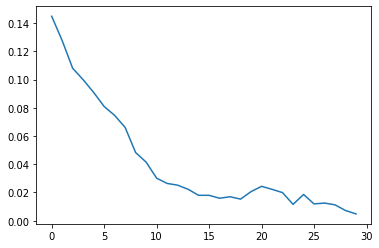

In [176]:
plt.plot(loss_history)
plt.savefig(f'loss_history_{plot_counter}.pdf')
np.save(f'loss_history_{plot_counter}.npy', loss_history)

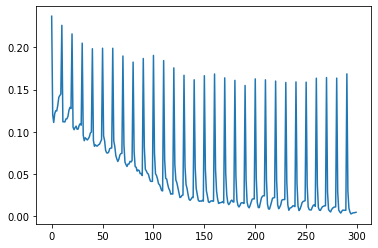

In [177]:
plt.plot(internal_loss_history)
plt.savefig(f'internal_loss_history_{plot_counter}.pdf')
np.save(f'internal_loss_history_{plot_counter}.npy', loss_history)

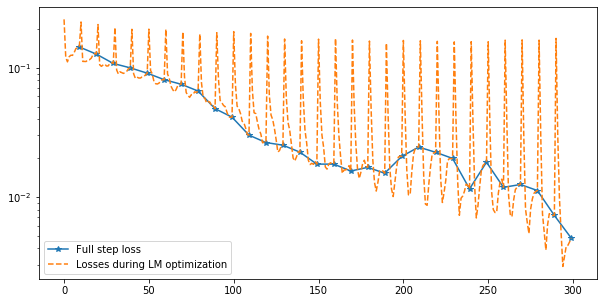

In [179]:
plt.figure(figsize=(10, 5))
plt.semilogy(np.arange(len(loss_history)) * internal_iter + internal_iter - 1, loss_history, '-*', label='Full step loss')
plt.semilogy(np.arange(len(internal_loss_history)), internal_loss_history, '--', label='Losses during LM optimization')
plt.legend()
plt.savefig(f'internal_and_full_{plot_counter}.pdf')
plt.savefig(f'internal_and_full_{plot_counter}.png')

In [72]:
depth_first.min(), depth_first.max()

(tensor(6.1311, dtype=torch.float64, grad_fn=<MinBackward1>),
 tensor(15., dtype=torch.float64, grad_fn=<MaxBackward1>))

In [73]:
depth_first_img_gt.min(), depth_first_img_gt.max()

(6.15234375, 15.0)

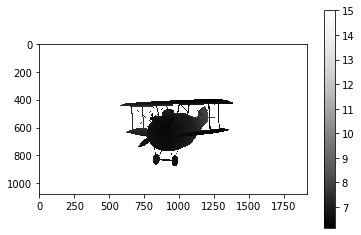

In [56]:
visualize_pcd(pc0, pc1)